Fix some input differences $\Delta$ and a sequence of segments $s_1 \hookrightarrow s_2 \hookrightarrow \dots \hookrightarrow s_n$. The search for an optimal coupling strategy can be formulated as the following optimization problem:

\begin{align}
\min_{\gamma} \sum_{i = 0}^n \sum_{k = 0}^{t_i} |\Delta_{k}^i - \gamma_k^i|
\end{align}

subject to the constraints

- If transition $k$ on segment $i$ outputs `insample`, then $\gamma_k^i = 0$.
- If transition $k$ on segment $i$ belongs to a cycle, then $\gamma_k^i = \Delta_k^i$.
- If transition $k$ on segment $i$ has guard:
  - `insample < x`, then $\gamma_k^i \leq \gamma_0^i$
  - `insample >= x`, then $\gamma_k^i \geq \gamma_0^i$
- If $s_i \hookrightarrow s_j$ and $guard(s_j)$ is:
  - `insample < x`, then $\gamma_0^j \leq \gamma_0^i$
  - `insample >= x`, then $\gamma_0^j \geq \gamma_0^i$
- $\forall k. \forall i: -1 \leq \gamma^i_k \leq 1$

Let's perform some tests to see whether these conditions make sense. First, let's try it on SVT:

In [5]:
# SVT

import numpy as np
import cvxpy as cp

n = 1
k = 3
deltas = [[1, 1, 1], ]
gammas = [[cp.Variable() for _ in range(k)] for i in range(n)]
objective = cp.Minimize(
    cp.abs(deltas[0][0] - gammas[0][0]) + cp.abs(deltas[0][2] - deltas[0][2])
)
constraints = [
    gammas[0][1] <= gammas[0][0],  # < transition
    gammas[0][0] <= gammas[0][2],  # >= transition
    gammas[0][1] == deltas[0][1]  # belongs to a cycle
]
for segment in gammas:
    for gamma in segment:
        constraints.append(-1 <= gamma)
        constraints.append(gamma <= 1)

prob = cp.Problem(objective, constraints)

result = prob.solve()

print(result)
for row in gammas:
    print([gamma.value for gamma in row])

2.0678458945155853e-11
[array(1.), array(1.), array(1.)]


In [6]:
# A_sort

n = 1
k = 5
deltas = [[0, 1, -1, -1, 1], ]
gammas = [[cp.Variable() for _ in range(k)] for i in range(n)]
objective = cp.Minimize(
    cp.abs(deltas[0][0] - gammas[0][0]) + cp.abs(deltas[0][2] - deltas[0][2])
)
constraints = [
    gammas[0][1] <= gammas[0][0],  # 1 --> 1 is a < transition
    gammas[0][1] == deltas[0][1],  # 1 --> 1 is on a cycle
    gammas[0][2] >= gammas[0][0],  # 1 --> 2 is a >= transition
    gammas[0][3] >= gammas[0][0],  # 2 --> 2 is a >= transition
    gammas[0][3] == deltas[0][3],  # 2 --> 2 is on a cycle
    gammas[0][4] <= gammas[0][0],  # 2 --> 3 is a < transition
]
for segment in gammas:
    for gamma in segment:
        constraints.append(-1 <= gamma)
        constraints.append(gamma <= 1)

prob = cp.Problem(objective, constraints)

result = prob.solve()

print(result)
for row in gammas:
    print([gamma.value for gamma in row])

inf
[None, None, None, None, None]


Multiple segments of SVT linked together

In [17]:
n = 4  # number of segments
k = 3  # number of transitions per segment
deltas = [[-1, 1, -1] for _ in range(n)]
gammas = [[cp.Variable() for _ in range(k)] for i in range(n)]
constraints = [
                  gammas[i][1] <= gammas[i][0] for i in range(n)  # < transitions
              ] + [
                  gammas[i][1] == deltas[i][1] for i in range(n)  # the < transitions are in a cycle
              ] + [
                  gammas[i][2] >= gammas[i][0] for i in range(n)  # >= transitions
              ] + [
                  -1 <= gammas[i][j] for i in range(n) for j in range(k)  # gammas are >= -1
              ] + [
                    gammas[i][j] <= 1 for i in range(n) for j in range(k)  # gammas are <= 1
                ]
objective = cp.Minimize(
    sum([cp.abs(deltas[i][0] - gammas[i][0]) + cp.abs(deltas[i][2] - deltas[i][2]) for i in range(n)])
)

prob = cp.Problem(objective, constraints)

result = prob.solve()

print(result)
for row in gammas:
    print([gamma.value for gamma in row])

7.999999997958275
[array(1.), array(1.), array(1.)]
[array(1.), array(1.), array(1.)]
[array(1.), array(1.), array(1.)]
[array(1.), array(1.), array(1.)]


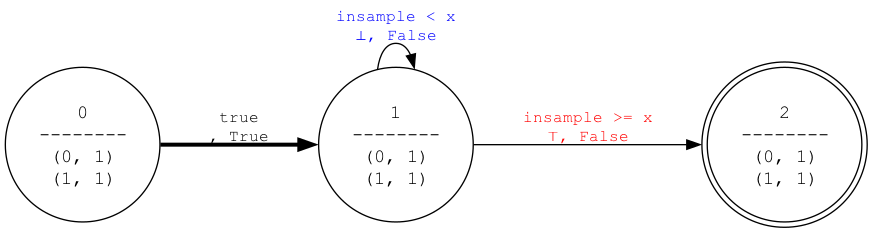

In [1]:
from helpers.dipa_constructors import construct_svt_dipa
from classes.DiPAPresenter import DiPAPresenter
from classes.DiPAGraph import DiPAGraph
from IPython.display import Image

dipa = construct_svt_dipa()
presenter = DiPAPresenter(dipa)
image = presenter.visualize()
Image(image)

# get the segments of the dipa
graph =